In [1]:
import pandas as pd

ndf=pd.read_csv('vocab-filtered', delimiter=' ', header=None)

In [2]:
words=ndf[0].to_numpy()
counts = ndf.to_dict('split')
mapping = {}
for k,v in counts['data']:
  mapping[v] = k

In [3]:
import nltk
nltk.edit_distance("humpty", "dumpty")

def strip_vowels(tstr):
  res = set([])
  for chr in tstr: 
    if chr not in "aeiouAEIOU": 
        res.add(chr) 
  res = "".join(res) 
  return res

count = 0
replace_map = {}

for word1 in words:
  for word2 in words:
    if(abs(len(word1) - len(word2)) < 3 and word1 != word2 and word1[:1] == word2[:1] and word1[-1] == word2[-1]):
      ed =  nltk.edit_distance(word1, word2)
      ratio =  ed / max(len(word1), len(word2))
      con1 = strip_vowels(word1)
      con2 = strip_vowels(word2)
      if ratio < 0.3 and con1 == con2 and  word1 not in replace_map.values():
        # print(word1, '[', mapping[word1], ']', word2, '[', mapping[word2], ']', ed, ratio)
        replace_map[word1] = word2
        count += 1
        break

print('-'*80, '\n', 'Total Matches',count)


-------------------------------------------------------------------------------- 
 Total Matches 89


In [4]:
#%matplotlib inline
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
import numpy as np
import pandas as pd
import os
import re
import time
from gensim.models import Word2Vec
from gensim.models import FastText
#from gensim.models.wrappers import FastText
from tqdm import tqdm
from pprint import pprint
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 
from google.colab import files
import io
from sklearn.metrics import classification_report

#uploaded = files.upload()
data_path = '/content/drive/My Drive/DataScience/data.txt'
f = open(data_path, "r")

#print(Sentences[2][1])
df = pd.DataFrame()
Sentences=[]
count=0
for s in f:
    a=0
    d=[]
    count+=1
    if ";" in s:
        '''if s.count(';') != 2:   Finding number of wrongly formatted lines
            print(count)'''
        b = s.split(";")
        #print(b[2])
        b[2] = b[2].lower()
    #print(len(b[2]))
        for x in range(len(b[2])):
            if (b[2][x] == '.' or b[2][x] == '?' or b[2][x] == '!' or b[2][x] == '…'):
                d.append(b[2][a:x])
                a=x+1
        df.loc[count, "Name"] = b[1]
        df.loc[count, "Utterance"] = b[2]


        for x in range(len(d)):
            sent = d[x].translate({ord(i): None for i in ',-.'})
            Sentences.append(sent.split()) # Need to remove non-alphabetical characters from the lists

#df.to_csv('DataTable.csv')
#print(Sentences)

df['Name'] = df['Name'].replace(['Hero', 'Varun', ' Varunu', '06-18:08:Varun', 'varun', ' Varun'], 'Varun')
df['Name'] = df['Name'].replace(['Balraju', 'Bala Raju', 'bala Raju', 'Bala raju', ' Bala Raju'], 'Balraju')
df['Name'] = df['Name'].replace(['Heroine', 'Jagadamba', 'J', 'Jagadhamba', 'Jagdamba', 'Jagadhmba', 'Jagdhamba', ' Jagadhamba', 'Jgadhamba', 'Jagadhama'], 'Jagadamba')
df['Name'] = df['Name'].replace(['krishna', 'Krshna', 'Krishana', 'Kroshna'], 'Krishna')
df['Name'] = df['Name'].replace(['Heroine father', 'Jagadamba father', 'J father', 'Guravayya', 'Guravayy', ' J father', 'Guravyya'], 'Guruvayya') 
df['Name'] = df['Name'].replace(['Heroine grandma', 'Jagadamba grandma', 'J Grand mother', 'Baamma', 'J Grand Mother', 'Grand Mother'], 'J grandma')
df['Name'] = df['Name'].replace(['Boss'], 'Ramesh')
df['Name'] = df['Name'].str.replace('J.s Grand Moyther', 'J grandma', regex=True)
df['Name'] = df['Name'].str.replace('J.s Grand Mother', 'J grandma', regex=True)
df['Name'] = df['Name'].str.replace('Jagadhamba.s Grand Mother', 'J grandma', regex=True)
df['Name'] = df['Name'].str.replace('J.sGrand Mother', 'J grandma', regex=True)
df['Name'] = df['Name'].str.replace('Heroin.s Grand Mother', 'J grandma', regex=True)
df['Name'] = df['Name'].str.replace('Hero-in.s Father', 'Guruvayya', regex=True)
df['Name'] = df['Name'].str.replace('Heroin.s Father', 'Guruvayya', regex=True)
#AllNames = df['Name'].unique().tolist()

Dialogues_by_Speaker = df.groupby("Name")["Utterance"].count().nlargest(40)
print(Dialogues_by_Speaker.head(40))

df.loc[:, 'Labels'] = "Other"
df.loc[df['Name'] == 'Varun', 'Labels'] = "Varun"
df.loc[df['Name'] == 'Balraju', 'Labels'] = "Balraju"
df.loc[df['Name'] == 'Jagadamba', 'Labels'] = "Jagadamba"
df.loc[df['Name'] == 'Krishna', 'Labels'] = "Krishna"
df.loc[df['Name'] == 'Guruvayya', 'Labels'] = "Guruvayya"
df.loc[df['Name'] == 'Ramesh', 'Labels'] = "Ramesh"

print(df.head(20))
#pprint(AllNames)


''' Gensim Word2Vec code 
start_time = time.time()

model =  Word2Vec(sentences=Sentences, size=100, window=5, min_count=3, workers=4, sg=0)
print(f'Time taken : {(time.time() - start_time) / 60:.2f} mins')
# '''
for i in range(len(Sentences)):
  dialogue = Sentences[i]
  for j in range(len(dialogue)):
    word = dialogue[j]
    if word in replace_map.keys():
      Sentences[i][j] = replace_map[word]

embedding_dim=300

model = FastText(Sentences, size=embedding_dim, window=5, min_count=1, workers=4, sg=0)
#model = FastText.load_fasttext_format(Sentences)
print(len(model.wv.vocab.keys()))
print(model.wv.vector_size)
#print(model.wv.get_vector('assalu'))
print(model.wv.most_similar('assalu'))
model.wv.save_word2vec_format('FastTextVectorsFinal.txt', fvocab = 'Vocab')



Name
Varun            1232
Jagadamba         715
Krishna           660
Balraju           400
Guruvayya         232
Ramesh            197
Mahesh            168
Ranga             162
J grandma         132
Nikhil            124
Madhur            118
SB                100
Shobhan Babu       91
Baali Reddy        86
Sasmitha           73
Puli               72
Apsara             67
SSK                67
KS                 63
Divya              61
Rambabu            54
J mother           51
Simham             49
Rangi              40
Varun grandma      38
Jack               37
Sai Reddy          37
Sash               36
Kodi Raju          35
Bhavani            34
Varun father       34
Sarayu             33
Sree Reddy         33
Kaveri             31
Boo                30
RSK                29
Barbie             28
EM                 28
Roo                28
Paidiraju          26
Name: Utterance, dtype: int64
               Name  ...     Labels
1          Narrator  ...      Other
3     Man1(Br

In [6]:
from sklearn.model_selection import train_test_split
#from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer

labels = df['Labels'].values
sentences = df['Utterance'].values

#categorical_labels = to_categorical(labels, num_classes=7)
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, labels, test_size = 0.25, random_state=1000)

lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

In [7]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=13000, lower=True)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1

print(sentences_train[2])
print(X_train[2])

 poye mundhu vache dhanne aakhari korika antaru.

[2459, 86, 1026, 2460, 1027, 1792, 389]


In [8]:
from keras.preprocessing.sequence import pad_sequences

def pad_repeat(A, size=100):
  return np.vstack([np.resize(A[i], size) for i in range(len(A))])

maxlen = 100

X_train=pad_repeat(X_train,maxlen)
X_test=pad_repeat(X_test,maxlen)

X_train = X_train[y_train.argmax(axis=1) != 4]
y_train = y_train[y_train.argmax(axis=1) != 4]
y_train = np.hstack([y_train[:,:4], y_train[:, 5:]])

X_test = X_test[y_test.argmax(axis=1) != 4]
y_test = y_test[y_test.argmax(axis=1) != 4]
y_test = np.hstack([y_test[:,:4], y_test[:, 5:]])


# X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
# X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [9]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
    
    return embedding_matrix


#uploaded=files.upload()
embedding_matrix = create_embedding_matrix('FastTextVectorsFinal.txt', tokenizer.word_index, embedding_dim)

# New Section

In [10]:
import tensorflow.keras as keras
import sys

class LossAndErrorPrintingCallback(keras.callbacks.Callback):
    # def on_train_batch_end(self, batch, logs=None):
    #     sys.stdout.write("\rFor batch {}, loss is {:7.2f}.".format(batch, logs["loss"]))

    # def on_test_batch_end(self, batch, logs=None):
    #     sys.stdout.write("\rFor batch {}, loss is {:7.2f}.".format(batch, logs["loss"]))

    def on_epoch_end(self, epoch, logs=None):
        sys.stdout.write("\rEpoch finished {:d}.".format(epoch))


In [11]:
import numpy as np


class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=0):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))


In [105]:
from keras.models import Sequential, Model
from keras.layers.merge import Concatenate, Average   
from keras import layers
from tensorflow.keras.layers import Dense, LSTM, Embedding,Dropout,SpatialDropout1D,Conv1D, Conv2D,MaxPooling2D, MaxPooling1D,GRU,BatchNormalization
from tensorflow.keras.layers import Input,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate,LeakyReLU, Flatten, ReLU
from tensorflow.keras import regularizers
import sys
from keras import backend as K
from keras.layers.core import Lambda

def element_max(X):
  # print(X.shape)
  return K.max(X, axis=2, keepdims=True)

# element_max([2,3])
kernel_size = 4
input_shape = (maxlen,)
model_input = Input(shape=input_shape)
EmbedLayer = Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False)(model_input)
EmbedLayer = Dropout(0.5)(EmbedLayer)

Filter1 = Conv1D(110, kernel_size=(kernel_size), kernel_regularizer=regularizers.l2(0.1))(EmbedLayer)
Filter1 = ReLU()(Filter1)
model_output = Lambda(element_max)(Filter1)
#model1.add(SpatialDropout1D(0.5))
# Filter1 = Flatten()(Filter1)


# Filter2 = Conv1D(100, kernel_size=(10),kernel_regularizer=regularizers.l2(0.00001), padding='same')(EmbedLayer)
# Filter2 = LeakyReLU(alpha=0.2)(Filter2)
# Filter2 = MaxPooling1D(pool_size=2)(Filter2)
# #model2.add(SpatialDropout1D(0.5))
# Filter2 = Flatten()(Filter2)

# merged = Concatenate()([Filter1, Filter2])

# merged = Dropout(0.8)(merged)
#model = Concatenate()([model1, model2])
#model.add(Bidirectional(LSTM(50,dropout=0.5, recurrent_dropout=0.5)))
# merged = Dense(10, activation='relu')(merged)
# model_output = Dense(6,activation='softmax')(merged)

model = Model(model_input, model_output)
model.compile()
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
model.summary()

extractor = keras.Model(inputs=model.input,
                        outputs=[model.layers[-1].output])


Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 300)          3408000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 300)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 97, 110)           132110    
_________________________________________________________________
re_lu_3 (ReLU)               (None, 97, 110)           0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 97, 1)             0         
Total params: 3,540,110
Trainable params: 132,110
Non-trainable params: 3,408,000
___________________________________________

In [106]:
# def element_max(X):
#   return K.max(X, axis=2, keepdims=True)

# A=np.arange(500).reshape(1,10,50)

# A.shape, element_max(A).shape

model_output.shape

TensorShape([None, 97, 1])

In [107]:
features = extractor(X_train)
history=model.fit(X_train, X_train, epochs=5)


Epoch 1/5
81/81 [==============================] - 0s 2ms/step - loss: 5.6952
Epoch 2/5
81/81 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 3/5
81/81 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 4/5
81/81 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 5/5
81/81 [==============================] - 0s 2ms/step - loss: 0.0033


(2561, 100) (2561, 97, 1)


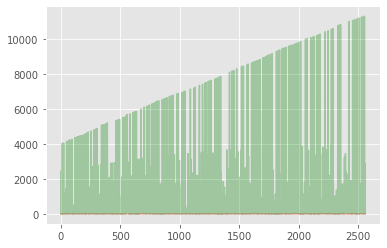

In [108]:
X_pred=features.numpy()

print(X_train.shape, X_pred.shape)

plt.plot(X_pred[:, 0, 0], alpha=0.3, color='r')
plt.plot(X_train[:, 0], alpha=0.3, color='g')
plt.show()

In [109]:
outlen=maxlen-kernel_size+1

def prepare_input(D):
  before1 = np.roll(D, shift=-1, axis=0)#.reshape(-1,1, outlen,1)
  before2 =  np.roll(D, shift=-2)#.reshape(-1,1, outlen,1)
  after2 =  np.roll(D, shift=2)#.reshape(-1,1, outlen,1)
  after1 =  np.roll(D, shift=1)#.reshape(-1,1, outlen,1)
  # print(D.shape)
  return np.hstack((before2, before1, D, after1, after2)).reshape(-1,5,outlen,1)
  # return np.hstack((before1, D, after1)).reshape(-1,3,outlen,1)

X_train_new = prepare_input(model.predict(X_train))
X_test_new = prepare_input(model.predict(X_test))
# X_train_new = prepare_input(X_train)
# X_test_new = prepare_input(X_test)

In [110]:
X_train_new.shape, y_train.shape, X_train.shape

((2561, 5, 97, 1), (2561, 6), (2561, 100))

In [111]:
from keras.models import Sequential, Model
from keras.layers.merge import Concatenate, Average   
from keras import layers
from tensorflow.keras.layers import Reshape,Dense, LSTM, Embedding,Dropout,SpatialDropout1D,Conv1D, Conv2D,MaxPooling2D, MaxPooling1D,GRU,BatchNormalization
from tensorflow.keras.layers import Input,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate,LeakyReLU, Flatten, TimeDistributed
from tensorflow.keras import regularizers
import sys

#option 1
inputA = Input(shape=(outlen,1))
inputB = Input(shape=(outlen,1))
inputC = Input(shape=(outlen,1))
inputD = Input(shape=(outlen,1))
inputE = Input(shape=(outlen,1))
inputs = [inputA, inputB, inputC, inputD, inputE]
com=concatenate(inputs)
FF1=Dense(1, activation='tanh')(com)
FF2=Flatten()(FF1)
output=Dense(units=6, activation='softmax')(FF2)
model1 = Model(inputs=inputs, outputs=output)


# # option 2
# inputs = Input(shape=X_train_new.shape[1:])
# # EmbedLayer = Embedding(vocab_size, embedding_dim, 
# #                            weights=[embedding_matrix], 
# #                            input_length=maxlen, 
# #                            trainable=False)(inputs)
# FF1=Dense(units=1, activation='tanh')
# TD=TimeDistributed(FF1)(inputs)
# FF2=Flatten()(TD)
# output=Dense(units=6, activation='softmax')(FF2)

# model1 = Model(inputs, output)
model1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model1.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 97, 1)]      0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           [(None, 97, 1)]      0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 97, 1)]      0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           [(None, 97, 1)]      0                                            
___________________________________________________________________________________________

In [124]:
import matplotlib.pyplot as plt
import argparse

Data = [X_train_new[:,0], X_train_new[:,1], X_train_new[:,2], X_train_new[:,3], X_train_new[:,4]]
# Data = X_train_new

history = model1.fit(Data, y_train,
                    epochs=2900,
                    verbose=False,
                    validation_split=0.1,
                    batch_size=128,)
                    # callbacks=[LossAndErrorPrintingCallback()]) #EarlyStoppingAtMinLoss(15)])


(11359, (2561, 5, 97, 1))

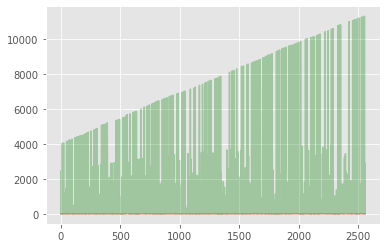

In [125]:
plt.plot(X_train_new[:,0, 0], alpha=0.3, color='r')
plt.plot(X_train[:, 0], alpha=0.3, color='g')
X_train.max(), X_train_new.shape

In [126]:
# from tensorflow import keras
# from tensorflow.keras import layers

# model_m = Sequential()
# # X_train_new1=X_train_new.reshape(X_train_new.shape[:-1])
# print(X_train_new.shape)
# # inputs = Input(shape=)
# model_m.add(Input(shape=X_train_new.shape[1:-1]))
# model_m.add(Embedding(vocab_size, embedding_dim, 
#                            weights=[embedding_matrix], 
#                            input_length=maxlen, 
#                            trainable=False))
# model_m.add(Conv1D(100, 5, activation='relu'))
# model_m.add(Conv1D(100, 10, activation='relu'))
# model_m.add(MaxPooling1D(3))
# model_m.add(Conv1D(160, 10, activation='relu'))
# model_m.add(Conv1D(160, 10, activation='relu'))
# model_m.add(GlobalAveragePooling1D())
# model_m.add(Dropout(0.5))
# model_m.add(Dense(6, activation='softmax'))
# print(model_m.summary())

# model_m.compile(loss='categorical_crossentropy',
#                 optimizer='adam', metrics=['accuracy'])


# extractor = keras.Model(inputs=model_m.inputs,
#                         outputs=[model_m.layers[1].output])

In [127]:
# import matplotlib.pyplot as plt
# import argparse

# # Data = [X_train_new[:,0], X_train_new[:,1], X_train_new[:,2]]
# # Data = X_train.reshape(*X_train.shape, 1)
# Data = X_train_new[:-1]
# features = extractor(Data)

# history = model_m.fit(Data, y_train,
#                     epochs=5,
#                     verbose=False,
#                     validation_split=0.1,
#                     batch_size=128,
#                     callbacks=[LossAndErrorPrintingCallback()]) #EarlyStoppingAtMinLoss(15)])



(2561, 5, 97, 1) (2561, 97, 1)


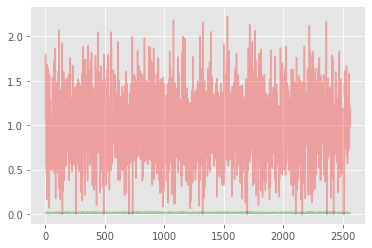

In [128]:
X_pred=features.numpy()

print(X_train_new.shape, X_pred.shape)

plt.plot(X_pred[:,0, 0], alpha=0.3, color='r')
plt.plot(X_train_new[:,0, 0], alpha=0.3, color='g')
plt.show()

[INFO] evaluating network...
[5 5 2 3 5 2 5 5 3 2 5 2 5 2 5 5 5 5 5 5 0 5 5 5 2 5 5 5 2 5 5 5 5 3 5 5 5
 4 5 5 5 5 2 5 2 5 5 0 5 5 5 1 5 3 0 5 1 5 5 5 5 5 5 5 5 3 2 5 5 5 2 2 5 5
 3 5 2 5 5 5 2 0 5 5 5 2 5 2 5 5 5 5 5 2 5 2 3 5 0 3 5 5 5 5 5 5 5 5 2 2 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 5 5 3 5 5 5 5 5 3 5 5 2 5 1 5 5 5 5 5 5 5 5
 5 5 5 0 5 3 2 5 5 5 5 5 5 5 5 4 5 5 5 5 5 2 1 5 5 5 5 5 5 5 2 0 0 2 5 5 5
 5 5 5 5 5 5 5 5 5 2 5 5 3 5 5 5 5 2 5 2 5 5 5 3 5 5 5 5 5 5 5 5 3 5 5 5 5
 5 5 5 5 5 0 3 5 5 5 5 5 5 5 5 5 5 3 5 5 5 5 5 5 0 5 5 5 5 1 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 3 5 5 0 5 5 5 5 5 5 2 2 5 5 5 5 3 5 5 5 5 5 3 5 5 5 5 5 5 5
 5 5 5 0 5 5 5 5 5 5 5 5 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 2 5 3 2 5 2 5
 5 5 2 5 5 5 2 2 2 5 3 5 5 0 5 0 5 3 2 5 5 5 5 5 5 5 5 5 5 5 5 2 5 5 5 5 5
 2 5 5 5 5 2 2 5 5 5 3 5 5 5 5 5 5 5 2 5 5 5 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 3 5 5 5 5 5 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 2 5 5 5 5 5 5 5 1 5
 5 5 5 5 2 3 3 0 5 5 5 5 5 5 2 5 5 5 5 5 5 5 5 5 5 5 5 5 1 5 5 5 5 4 5 

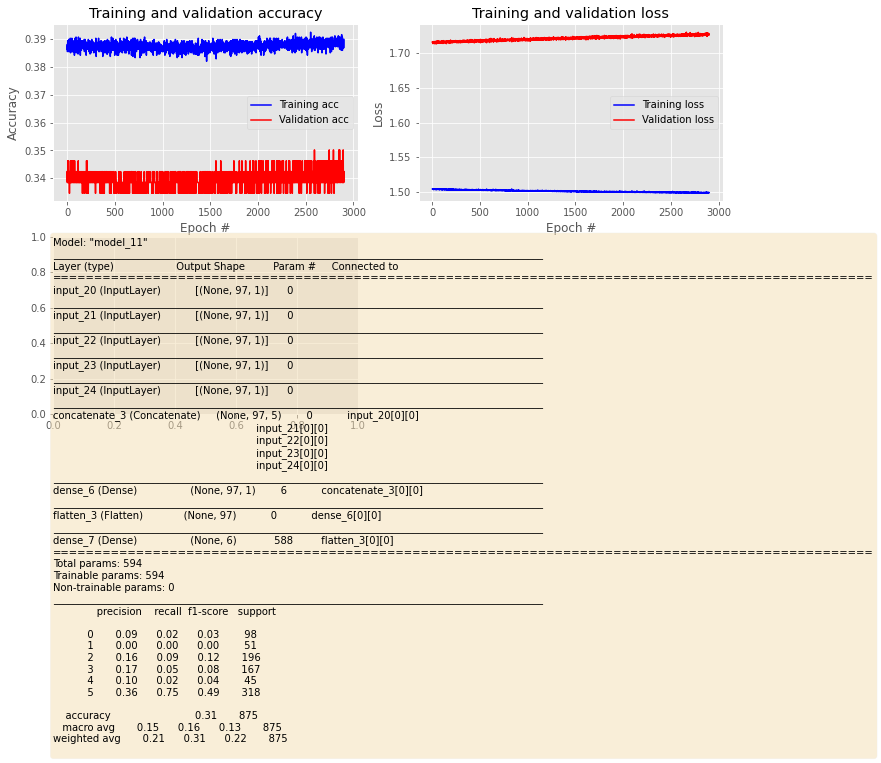

In [129]:
from scipy import stats
from datetime import datetime

TEST=[X_test_new[:,0], X_test_new[:,1], X_test_new[:,2], X_test_new[:,3], X_test_new[:,4]]
# TEST=X_test_new
# TEST=X_test.reshape(*X_test.shape,1)

print("[INFO] evaluating network...")
predictions = model1.predict(x=TEST, batch_size=16)
print(predictions.argmax(axis=1))
print(stats.describe(predictions.argmax(axis=1)))
print(y_test.argmax(axis=1))
class_report = classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1))
# print(class_report)

plt.style.use('ggplot')

def plot_history(history):
    #N = np.arrange(0, 50) #no of Epochs
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 15))
    plt.subplot(4, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.subplot(4, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend()
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    ax = plt.subplot(4, 2, 3)
    stringlist = []
    model1.summary(print_fn=lambda x: stringlist.append(x))
    short_model_summary = "\n".join(stringlist) 
    short_model_summary += '\n' + class_report
# place a text box in upper left in axes coords
    ax.text(0.00, 1.0, short_model_summary , fontsize=10, verticalalignment='top', bbox=props)
    fname = f'/content/drive/MyDrive/DataScience/Results/{datetime.now().timestamp()}'
    # plt.savefig(fname[:-7])

plot_history(history)

print("[INFO] serializing network and label binarizer...")
#model.save(args["model"], save_format="h5")